## Implementing an SVM to classify animals and vehicles from CIFAR-10

Isidoros Tsaousis-Seiras, AEM: 10042, THMMY
[github repository](https://github.com/isidorostsa/svm-cifar)

In [202]:
import numpy as np
from numpy import linalg
from cvxopt import matrix, solvers
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from itertools import product

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

import matplotlib.pyplot as plt

import time

from helpers import *

In [326]:
trainset, testset = fetch_datasets()
cifar_len = len(trainset)
models = {}

x_train, y_train = trainset.data, trainset.targets
x_test, y_test = testset.data, testset.targets

assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

Files already downloaded and verified


The subject of this report is to train an `SVM` model to distinguish between animals and vehicles in the `CIFAR-10` dataset. The dataset consist of an equal number of each of the following categories: airplanes, cars, cats, dogs, frogs, horses, ships, and trucks.

There are 6 animals and 4 vehicles in the sets, so to have an equal number of animals and vehicles **we will disregard birds and deer** (categories chosen randomly).

We will give label = `-1` for vehicles and label = `1` for animals

The vehicles will have a label of `-1` and the animals `1`. This is required by the `SVM` implementation.

In [327]:
# remove birds and deer
birds = 2
deer = 4
remove = [birds, deer]

# Create a mask for y_train and y_test
mask_train = [y not in remove for y in y_train]
mask_test = [y not in remove for y in y_test]

# Apply the mask to y_train and y_test
y_train = [y for y, m in zip(y_train, mask_train) if m]
y_test = [y for y, m in zip(y_test, mask_test) if m]

# Apply the mask to x_train and x_test
x_train = x_train[mask_train]
x_test = x_test[mask_test]

# flatten data
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

# normalize data
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

animals = [2, 3, 4, 5, 6, 7]
y_train = [1 if y in animals else -1 for y in y_train]
y_test = [1 if y in animals else -1 for y in y_test]

assert x_test.shape == (1000*(10-len(remove)), 32*32*3)
assert x_train.shape == (5000*(10-len(remove)), 32*32*3)

Before implementing the svm, we will trim the features using PCA of various degrees. First we will review the generated images optically.

In [112]:
pcas = {i: PCA(n_components=0.9+0.01*i) for i in range(10)}

for pca in pcas.values():
   pca.fit(x_test)

We can inspect how well the compression is done by performing a transformation and then reversing that.

PCA with 90% of the explained variance, with 98 components


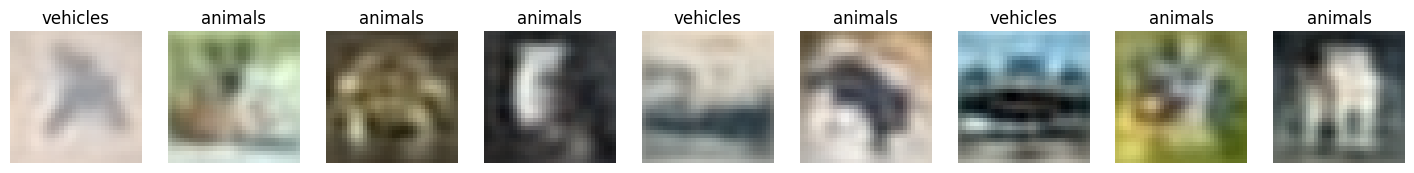

PCA with 94% of the explained variance, with 176 components


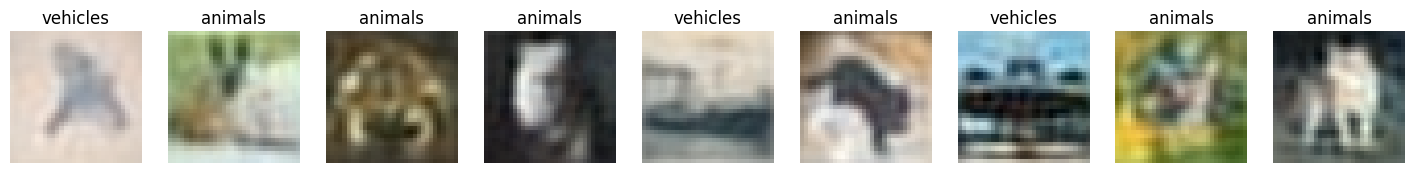

PCA with 98% of the explained variance, with 421 components


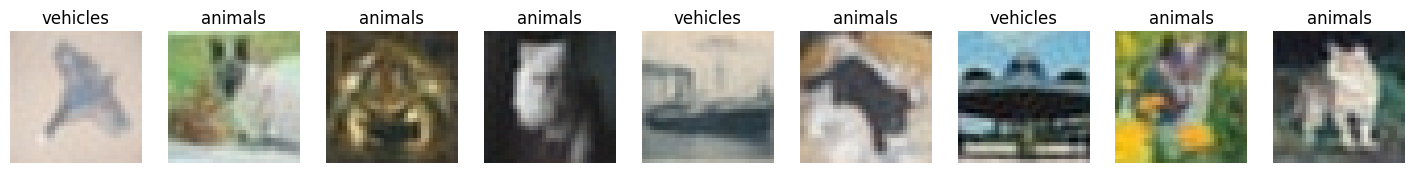

In [276]:
classes = {-1: "vehicles", 1: "animals"}

for i in range(0, 10, 4):
    print(f"PCA with {90+i}% of the explained variance, with {pcas[i].n_components_} components")
    show_reconstruction(pcas[i], x_test, y_test, classes, n=9, index=223)

Intrestingly, the `90%`-trimmed images seem difficult for humans to classify, but as we will see later, the `SVM` models can do it with high accuracy. 

We will use a base of `95%`` PCA to begin with, but more will be tested in the upcoming grid search section of the report. 

The next section will focus on understanding how we can implement SVMs using `QP`.

### Implementing the SVM

Given a decision hyperplane $w \cdot x + b = 0$, the margin between the decision boundaries is the distance between the hyperplanes $w \cdot x + b + 1 = 0$ and $w \cdot x + b - 1= 0$, which is equal to 
$$\frac{|(b-1) - (b+1)|}{\sqrt{A^2 + B^2 + C^2 + \ldots}} = \frac {2}{|w|}$$
So in order to maximize the margin, the objective is to minimize $|w|$ while still classifying the samples correctly. Expressed mathematically, $$y_i(w^Tx_i+b) \ge 1, \forall i$$

The lagrangian dual of this constrained problem is:
$$\begin{align*}
\max_{\lambda_i \geq 0} \quad & -\frac{1}{2} \sum_{i} \sum_{j} \lambda_i \lambda_j y_i y_j \text{kernel}(x^T_i, x_j) + \sum_{i} \lambda_i \\
\text{such that} \quad & \sum_{i} \lambda_i y_i = 0 \\
& 0 \leq \lambda_i \leq c, \quad \forall i
\end{align*}
$$

but we can rewrite the terms to transform this into a standard `QP` problem:
1. $$\sum_{i} \sum_{j} \lambda_i \lambda_j y_i y_j \text{kernel}(x^T_i, x_j) = \lambda^T Y K Y \lambda = \lambda^T P \lambda$$
2. $$\sum_{i} \lambda_i = 1^T \cdot \lambda$$
3. $$\quad \sum_{i} \lambda_i y_i = Y \cdot \lambda $$
4. $$0 \leq \lambda_i \leq c \implies G\lambda \leq h, \text{where} \\
    G = \begin{bmatrix} I \\ -I \end{bmatrix} \quad \text{and} \quad h = \begin{bmatrix} c\mathbf{1} \\ \mathbf{0} \end{bmatrix}
    $$

where $1$ and $0$ are column matrices. The result of the transformation is the `QP` problem
$$
\max_{\lambda} \quad -\frac{1}{2} \lambda^T P \lambda + \mathbf{1}^T \lambda
$$
Subject to the constraints:
$$
G\lambda \le h\\
A\lambda = 0
$$

In the following sections we will implement this, and solve it using the `cvxopt` `QP` solver.

In [277]:
class svm_classifier():
    def __init__(self, kernel, c=1, pca_preprocessor=None, sv_threshold = 1e-4) -> None:
        self.kernel = kernel
        self.c = c
        self.sv_threshold = sv_threshold
        self.pca_preprocessor = pca_preprocessor

    def preprocess(self, x: np.array):
        if not self.pca_preprocessor:
            return x
        return self.pca_preprocessor.transform(x)

    def fit(self, x_in: np.array, y_in: np.array):
        """ 
        The opimization problem we can solve with cvxopt is:
            minimize    (1/2)*x'*P*x + q'*x
            subject to  G*x <= h
                        A*x = b.
            
        We need to negate the terms to get the maximization problem
        so: q = [-1, -1 ...] and the first term will not be negated
        """

        x = self.preprocess(x_in)
        
        num_samples = len(x)

        # G and h are built with two sections because they need to apply two constraints
        G = matrix(np.vstack((-np.eye(num_samples), np.eye(num_samples))))
        h = matrix(np.vstack((np.zeros((num_samples,1)), self.c * np.ones((num_samples,1)))))

        # A, b, q are straightforward
        A = matrix(y_in.astype('d').reshape(1, -1))
        q = matrix(np.ones(num_samples) * -1.0)
        b = matrix(0.0)

        # the P matrix is Y * K * Y (Gram matrix)
        K = np.zeros((num_samples, num_samples))
        for i in range(num_samples):
            for j in range(num_samples):
                if i <= j:
                    K[i, j] = self.kernel(x[i], x[j])
                else: # kernels are commutative
                    K[i, j] = K[j, i]
        
        P = matrix(np.outer(y_in, y_in) * K)

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)

        # Get the alphas
        alphas = np.array(sol['x']).flatten()

        # Support vectors are the ones with large values of alpha
        sv = (alphas > self.sv_threshold).flatten()
        self.alphas = alphas[sv]
        self.sv_x = x[sv]
        self.sv_y = y_in[sv]

        # calculate the bias, 
        self.b = 0
        sv_num = 0
        # doing it step by step to avoid overflow
        for i in range(num_samples):
            if sv[i]:
                self.b += self.sv_y[sv_num]
                sv_num += 1
                self.b -= np.sum(self.alphas * self.sv_y * K[i, sv])

        if len(self.alphas) > 0:
            self.b /= len(self.alphas)


    def __call__(self, x: np.array):
        x = self.preprocess(x)

        y_prediction = np.zeros(len(x))
        for i in range(len(x)):
            for alpha, sv_y_val, sv_x_val in zip(self.alphas, self.sv_y, self.sv_x):
                y_prediction[i] += alpha * sv_y_val * self.kernel(x[i], sv_x_val)

            y_prediction[i] += self.b

        return np.sign(y_prediction)

We will examine 4 well known kernels.

In [278]:
def linear_kernel_factory():
    def linear_kernel(x, y):
        return np.dot(x, y.T)
    return linear_kernel

def polynomial_kernel_factory(d, r = 1):
    def polynomial_kernel(x, y):
        return (float(r) + np.dot(x, y.T)) ** d
    return polynomial_kernel

def gaussian_kernel_factory(gamma):
    def gaussian_kernel(x, y):
        return np.exp(-gamma * linalg.norm(x-y)**2)
    return gaussian_kernel

def anova_kernel_factory(sigma, d):
    def anova_kernel(x, y):
        return np.prod(np.exp(-sigma * (x - y) ** 2) ** d)
    return anova_kernel

Let's test this with a linear kernel and some example parameters.

In [279]:
# keep the first 1000 samples
x_train_svm = x_train[:1000]
y_train_svm = np.array(y_train[:1000])

svm = svm_classifier(kernel=linear_kernel_factory(), c=0.0001, sv_threshold=1e-6, pca_preprocessor=pcas[5])

with Timer():
    svm.fit(x_train_svm, y_train_svm)

x_test_svm = np.array(x_test[:400]) 

y_pred = svm(x_test_svm)

print(f"Accuracy: {accuracy_score(y_test[:400], y_pred)}, with {len(svm.alphas)} support vectors")

Elapsed time: 1.817 seconds
Accuracy: 0.82, with 602 support vectors


The spacial complexity of the `fit` algorithm is `O(n^2)` with respect to the sample size. This imposes a strict limitation on the size of the training sample.

The base model has an accuracy higher by ~20% compared the best model of the previous assignment. Let's take a closer look at the predictions/mispredictions

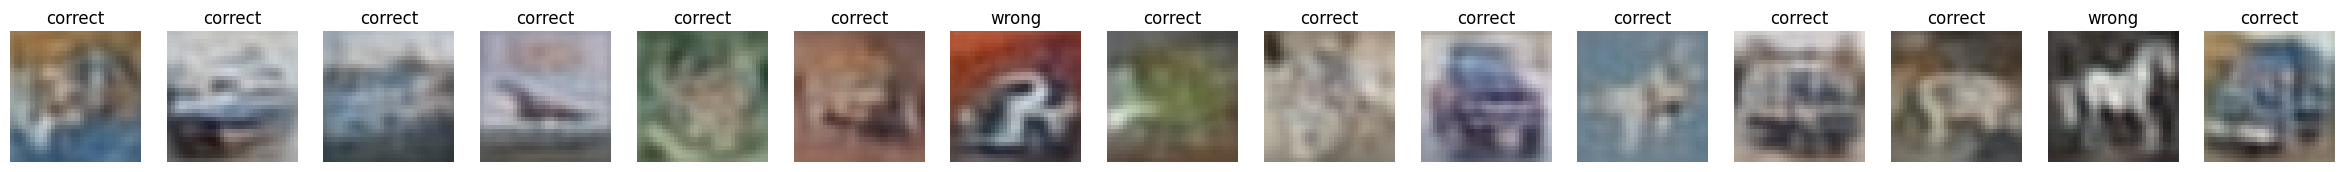

In [280]:
x_test_svm = pcas[3].transform(x_test_svm)
x_test_svm = pcas[3].inverse_transform(x_test_svm)

x_max = np.max(x_test_svm)
x_min = np.min(x_test_svm)
x_test_svm = (x_test_svm - x_min) / (x_max - x_min)

reconstructed_x_test_svm = x_test_svm.reshape(len(x_test_svm), 32, 32, 3)

# make the labels of the wrong predictions =0
y_pred[y_pred != y_test[:400]] = -2
y_pred[y_pred == y_test[:400]] = 2

classes[-2] = "wrong"
classes[2] = "correct"

show_images(reconstructed_x_test_svm, y_pred, classes, 15)

The model will be fine tuned using grid search.

In [ ]:
class parameter_pack:
    def __init__(self, kernel, kernel_params, c, pca, threshold):
        self.kernel = kernel
        self.c = c
        self.pca = pca
        self.threshold = threshold
        self.kernel_params = kernel_params

    def __str__(self) -> str:
        return f"kernel: {self.kernel}, {self.kernel_params}, c: {self.c}, pca: {self.pca}, threshold: {self.threshold}"

    def __repr__(self) -> str:
        return self.__str__()

In [251]:
def grid_search(kernel_parameters, c_values, thresholds, pca_types, num_samples=1000):
    global x_train, y_train, x_test, y_test
    results = {}
    for kernel_factory, kernel_params in kernel_parameters.items():
        for kernel_param in kernel_params:
            for c, threshold, pca in product(c_values, thresholds, pca_types):
                svm = svm_classifier(kernel=kernel_factory(*kernel_param.values()), c=c, sv_threshold=threshold, pca_preprocessor=pca)
                y_train_svm = np.array(y_train[:num_samples])
                svm.fit(x_train[:num_samples], y_train_svm)
                y_pred = svm(x_test[:400])
                time_start = time.time()
                accuracy = accuracy_score(y_test[:400], y_pred)
                duration = time.time() - time_start
                results[parameter_pack(kernel_factory, kernel_param, c, pca, threshold)] = {"accuracy_score": accuracy, "duration": duration}
                print(f"kernel params: {kernel_params}, c: {c}, pca: {pca}, threshold: {threshold}, duration: {duration}, accuracy: {accuracy}")
    return results

The parameters that will be tested are the following:

In [284]:
kernel_parameters = {
    linear_kernel_factory:[
        {}
    ],
    polynomial_kernel_factory:[
        {"d":d, "r":10**r} for d, r in product([2, 3, 4], [-2, -1, 0, 1, 2])
    ],
    gaussian_kernel_factory: [
        {"gamma": 10**i} for i in range(-5, 3)
    ],
    anova_kernel_factory:[
        {"sigma": 10**i, "d": d} for i, d in product([-5, -4, -3, -2, -1, 0], [2, 3, 4])
    ]
}

c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

thresholds = [1e-4, 1e-8, 1e-12]

pca_types = [pcas[0], pcas[5], pcas[9]]

In [283]:
result = grid_search(kernel_parameters, c_values, thresholds, pca_types)            

result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1]["accuracy_score"], reverse=True)}

print(f"The best configuration, reaching an accuracy of: {list(result.values())[0]['accuracy_score']} is:\n{list(result.items())[0]}")

The best configuration, reaching an accuracy of: 0.803 is:
(kernel: <function polynomial_kernel_factory at 0x713100a06ef0>, {'d': 3, 'r': 100}, c: 0.01, pca: PCA(n_components=0.99), threshold: 1e-12, {'accuracy_score': 0.803, 'duration': 0.001313924789428711})


### Interpreting the impact of hyper-parameters

It is difficult to reason what each parameter's impact is. To understand it, we will view the way the model behaves when a single parameter is changing, starting with a linear kernel and `c`.

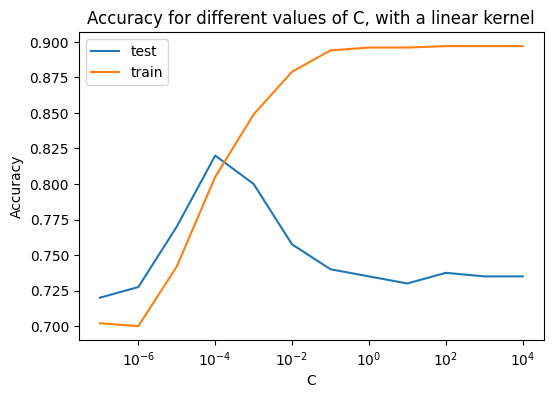

In [299]:
# keep the first 1000 samples
x_train_svm = x_train[:1000]
y_train_svm = np.array(y_train[:1000])

accuracy = {}

for c in [10**(i) for i in range(-7, 5)]:
    svm = svm_classifier(kernel=linear_kernel_factory(), c=c, sv_threshold=min(1e-6, c/2), pca_preprocessor=pcas[5])
    svm.fit(x_train_svm, y_train_svm)
    acc_test = accuracy_score(y_test[:400], svm(x_test[:400]))
    acc_train = accuracy_score(y_train_svm, svm(x_train_svm))

    accuracy[c] = {"test": acc_test, "train": acc_train}

# plot the accuracy
plt.figure(figsize=(6, 4))
plt.plot(list(accuracy.keys()), [v["test"] for v in accuracy.values()], label="test")
plt.plot(list(accuracy.keys()), [v["train"] for v in accuracy.values()], label="train")
plt.xscale("log")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy for different values of C, with a linear kernel")
plt.show()

The training accuracy (recall) keeps increasing while the validation accuaracy decreases. This leads to the conclusion that high values of `c` result in overfitting models. We will repeat this experiment with the gaussian kernel at a fixed `gamma`.

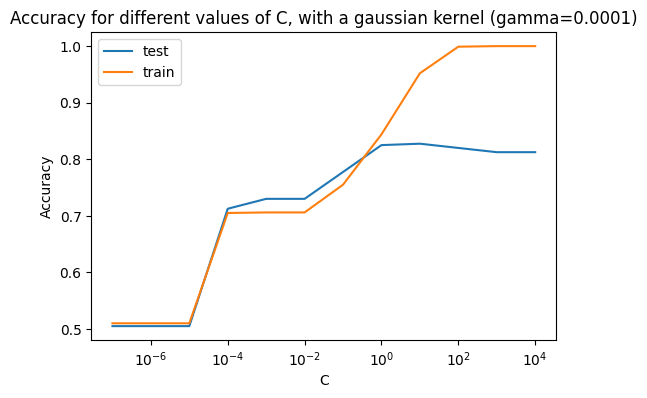

In [302]:
# keep the first 1000 samples
x_train_svm = x_train[:1000]
y_train_svm = np.array(y_train[:1000])

accuracy = {}

for c in [10**(i) for i in range(-7, 5)]:
    svm = svm_classifier(kernel=gaussian_kernel_factory(gamma=0.0001), c=c, sv_threshold=min(1e-6, c/2), pca_preprocessor=pcas[5])
    svm.fit(x_train_svm, y_train_svm)
    acc_test = accuracy_score(y_test[:400], svm(x_test[:400]))
    acc_train = accuracy_score(y_train_svm, svm(x_train_svm))

    accuracy[c] = {"test": acc_test, "train": acc_train}

# plot the accuracy
plt.figure(figsize=(6, 4))
plt.plot(list(accuracy.keys()), [v["test"] for v in accuracy.values()], label="test")
plt.plot(list(accuracy.keys()), [v["train"] for v in accuracy.values()], label="train")
plt.xscale("log")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy for different values of C, with a gaussian kernel (gamma=0.0001)")
plt.show()

The gaussian model presents overfitting as well. Next `c` will be fixed at `c = 1` and gamma will be variable.

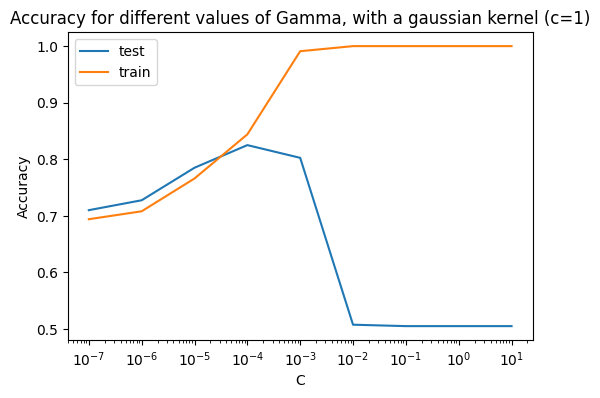

In [307]:
# keep the first 1000 samples
x_train_svm = x_train[:1000]
y_train_svm = np.array(y_train[:1000])

accuracy = {}

for g in [10**(i) for i in range(-7, 2)]:
    svm = svm_classifier(kernel=gaussian_kernel_factory(gamma=g), c=1.0, sv_threshold=min(1e-6, c/2), pca_preprocessor=pcas[5])
    svm.fit(x_train_svm, y_train_svm)
    acc_test = accuracy_score(y_test[:400], svm(x_test[:400]))
    acc_train = accuracy_score(y_train_svm, svm(x_train_svm))

    accuracy[g] = {"test": acc_test, "train": acc_train}
    print(f"gamma: {g}, accuracy: {acc_test}")

plt.figure(figsize=(6, 4))
plt.plot(list(accuracy.keys()), [v["test"] for v in accuracy.values()], label="test")
plt.plot(list(accuracy.keys()), [v["train"] for v in accuracy.values()], label="train")
plt.xscale("log")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy for different values of Gamma, with a gaussian kernel (c=1)")
plt.show()

This leads to an overfiting model too. Next we will see what happens when the degree of the polynomial kernel changes, while keeping `r=100`. Cross validation showed this to be the best choice for `d=3`.

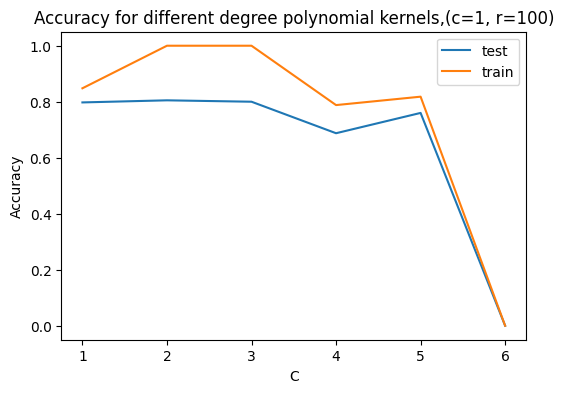

In [323]:
# keep the first 1000 samples
x_train_svm = x_train[:1000]
y_train_svm = np.array(y_train[:1000])

accuracy = {}

for d in [1, 2, 3, 4, 5, 6]:
    svm = svm_classifier(kernel=polynomial_kernel_factory(d, 100), c=0.001, sv_threshold=1e-16, pca_preprocessor=pcas[5])
    svm.fit(x_train_svm, y_train_svm)
    acc_test = accuracy_score(y_test[:400], svm(x_test[:400]))
    acc_train = accuracy_score(y_train_svm, svm(x_train_svm))

    accuracy[d] = {"test": acc_test, "train": acc_train}

plt.figure(figsize=(6, 4))
plt.plot(list(accuracy.keys()), [v["test"] for v in accuracy.values()], label="test")
plt.plot(list(accuracy.keys()), [v["train"] for v in accuracy.values()], label="train")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy for different degree polynomial kernels,(c=1, r=100)")
plt.show()

For higher order polynomials the accuracy drops drasically. This happens likely because the rest of the parameters are not tuned to support that kernel. 

### Comparing with KNN, NNC

In [341]:
knn_1 = KNeighborsClassifier(n_neighbors=1)

x_train_knn = x_train[:1000]
y_train_knn = y_train[:1000]

x_test_knn = x_test[:400]
y_test_knn = y_test[:400]

pca = pcas[5]

x_train_knn = pca.transform(x_train_knn)
x_test_knn = pca.transform(x_test_knn)

knn_1.fit(x_train_knn, y_train_knn)

y_pred = knn_1.predict(x_test_knn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_knn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.79


In [342]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

x_train_knn = x_train[:1000]
y_train_knn = y_train[:1000]

x_test_knn = x_test[:400]
y_test_knn = y_test[:400]

pca = pcas[5]

x_train_knn = pca.transform(x_train_knn)
x_test_knn = pca.transform(x_test_knn)

knn_3.fit(x_train_knn, y_train_knn)

y_pred = knn_3.predict(x_test_knn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_knn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.77


In [345]:
nn = NearestCentroid()

x_train_nn = x_train[:1000]
y_train_nn = y_train[:1000]

x_test_nn = x_test[:400]
y_test_nn = y_test[:400]

pca = pcas[5]

x_train_nn = pca.transform(x_train_nn)
x_test_nn = pca.transform(x_test_nn)

nn.fit(x_train_nn, y_train_nn)

y_pred = nn.predict(x_test_nn)

# Calculate and store the accuracy of the model on both train and test set
accuracy_test = accuracy_score(y_pred, y_test_nn)

print(f'Accuracy on test set: {accuracy_test:.2f}')

Accuracy on test set: 0.72


The accuracy using `PCA -> KNN / NN` is very high, almost as high as that of the original SVM (~81%). This is unexpected yet interesting, as it shows `PCA`'s strength in "understanding" the data.

### Thank you for your attention!